<a href="https://colab.research.google.com/github/Carlos2242525/Cabbage-Disease-Prediction/blob/main/CABBAGE_DISEASE_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary Libraries

This code imports essential libraries for handling files, processing images, visualizing data, and building a deep learning model.

In [22]:
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import numpy as np
from hashlib import md5
import tensorflow as tf
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

**Defining the Path for Cabbage Disease Dataset Extraction**

This code defines the path of a ZIP file containing the cabbage disease dataset and the destination folder where it will be extracted.

In [2]:
zip_path = "/content/ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES.zip"
extract_path = "/content/cabbage_dataset"

**Verifying and Extracting the Cabbage Disease Dataset**

This code checks if the specified ZIP file exists; if it does, it extracts its contents to the given directory. Otherwise, it notifies the user that the file is missing.









In [3]:
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete!")
else:
    print("ZIP file not found. Please upload it.")

Extraction complete!


**Checking Extracted Dataset and Listing Classes**

This code checks if the extraction folder exists; if it does, it lists and prints the classes (subdirectories) inside the dataset. Otherwise, it notifies the user that the extraction failed or the path is incorrect.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
if os.path.exists(extract_path):
    classes = os.listdir(extract_path)
    print("Classes inside cabbage_dataset:", classes)
else:
    print("Dataset extraction failed or path does not exist.")

Classes inside cabbage_dataset: ['ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES']


**Verifying Dataset Directory and Listing Classes**

This code checks if the specified dataset directory exists. If it does, it lists and prints the classes (subdirectories) inside it; otherwise, it notifies the user that the path is missing or the dataset extraction was unsuccessful.

In [5]:
dataset_path = "/content/cabbage_dataset/ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES"

if os.path.exists(dataset_path):
    classes = os.listdir(dataset_path)
    print("Classes inside ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES:", classes)
else:
    print("Path does not exist. Check the dataset extraction.")

Classes inside ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES: ['Cabbage_Altenaria_spot', 'Cabbage - Black_rot', 'Cabbage - Healthy', 'Cabbage downy mildew - Original']


# EXPLORATORY DATA ANALYSIS


**Check Class Distribution**

This code checks if the dataset directory exists. If it does, it counts and prints the number of classes (disease categories) and their names. It then calculates the number of images in each class and visualizes the class distribution using a bar plot. If the dataset path is missing, it alerts the user.

Number of classes: 4
Classes: ['Cabbage_Altenaria_spot', 'Cabbage - Black_rot', 'Cabbage - Healthy', 'Cabbage downy mildew - Original']


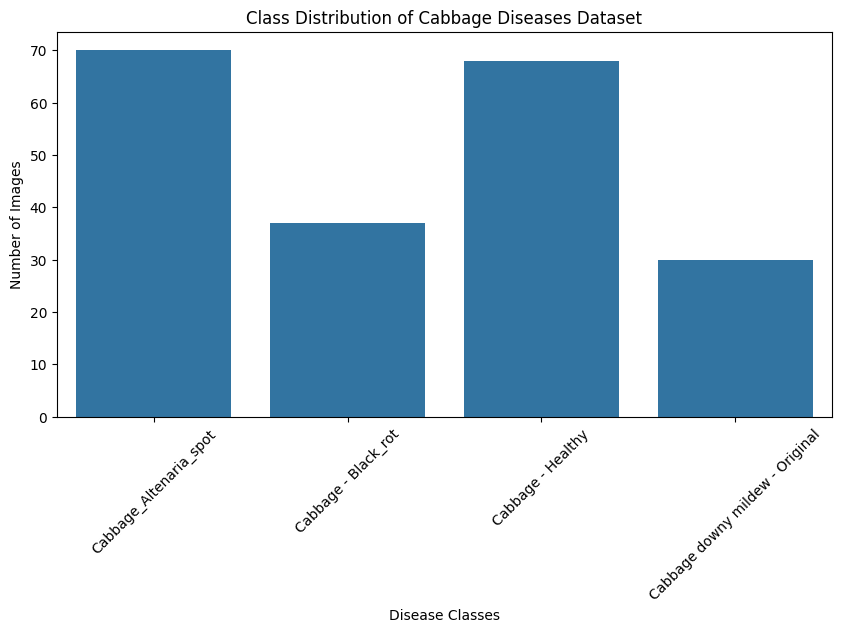

In [6]:
dataset_path = dataset_path = "/content/cabbage_dataset/ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES"

if os.path.exists(dataset_path):
    classes = os.listdir(dataset_path)
    print("Number of classes:", len(classes))
    print("Classes:", classes)

    class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

    # Plot class distribution
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.xticks(rotation=45)
    plt.xlabel("Disease Classes")
    plt.ylabel("Number of Images")
    plt.title("Class Distribution of Cabbage Diseases Dataset")
    plt.show()
else:
    print("Dataset path does not exist.")


**Display Sample Images**

This function, show_sample_images(), displays a few sample images from each class in the dataset. It loops through the disease categories, selects a specified number of images (default is 3), and plots them in a grid. Each image is displayed without axes, and the class name is used as the title. The function is then called to visualize the dataset's sample images.

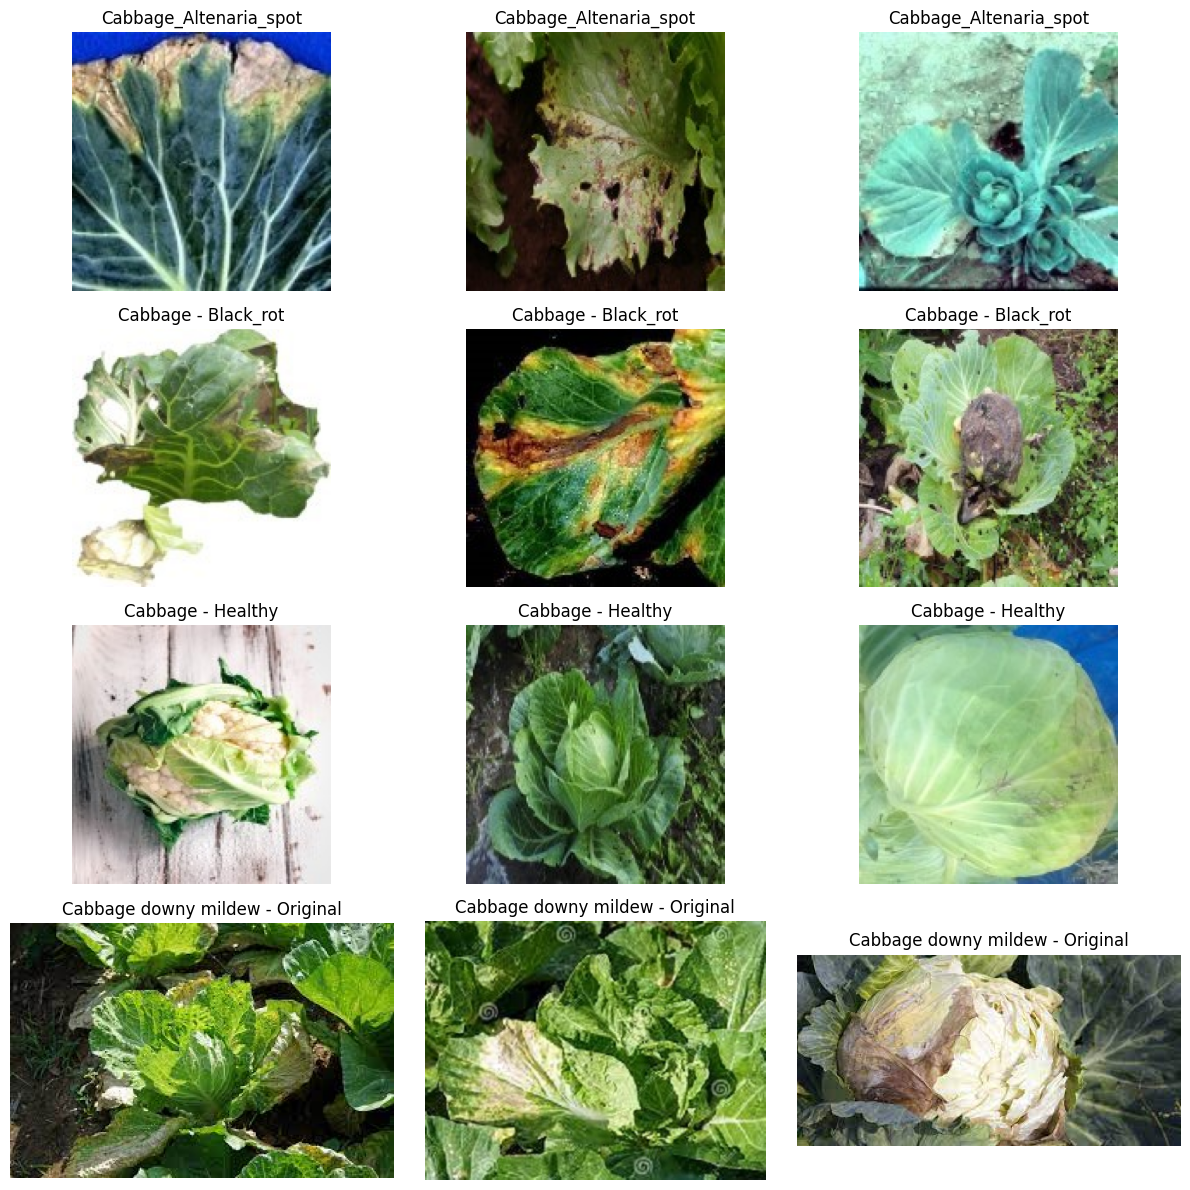

In [7]:
def show_sample_images(dataset_path, classes, num_samples=3):
    plt.figure(figsize=(12, len(classes) * 3))

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        images = os.listdir(class_path)[:num_samples]

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(cls)

    plt.tight_layout()
    plt.show()


show_sample_images(dataset_path, classes)

**Image Size Distribution**

This code analyzes the distribution of image sizes in the dataset. It collects the width and height of up to 50 images per class, stores them in a list, and then converts them into a NumPy array. Using Seaborn, it plots histograms with kernel density estimation (KDE) to visualize the frequency distribution of image widths and heights. Blue represents width, and red represents height.

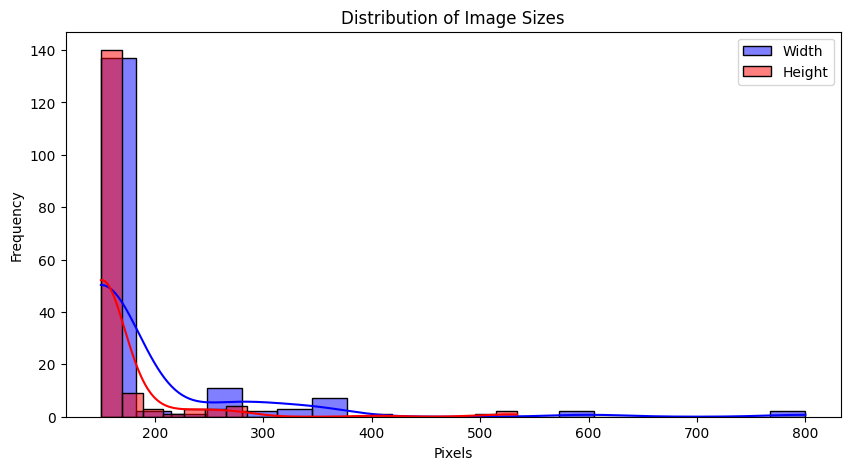

In [8]:
image_sizes = []
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    image_files = os.listdir(class_path)[:50]

    for img_name in image_files:
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        image_sizes.append(img.size)

# Convert sizes to NumPy array and plot
widths, heights = zip(*image_sizes)

plt.figure(figsize=(10, 5))
sns.histplot(widths, bins=20, color="blue", label="Width", kde=True)
sns.histplot(heights, bins=20, color="red", label="Height", kde=True)
plt.legend()
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.title("Distribution of Image Sizes")
plt.show()

**Check for Duplicate Images**

This code detects duplicate images in the dataset by computing a unique hash for each image file using the MD5 algorithm. It iterates through all images in each class, storing their hashes in a set. If an image's hash matches one already in the set, it is flagged as a duplicate and added to a list. Finally, the total number of duplicate images found is printed.

In [9]:
def get_file_hash(file_path):
    with open(file_path, "rb") as f:
        return md5(f.read()).hexdigest()

hashes = set()
duplicates = []

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        file_hash = get_file_hash(img_path)

        if file_hash in hashes:
            duplicates.append(img_path)
        else:
            hashes.add(file_hash)

print(f"Found {len(duplicates)} duplicate images.")


Found 14 duplicate images.


**Removing Duplicate Images from the Dataset**

This code removes duplicate images from the dataset. It iterates through the list of duplicate image paths and deletes each file using os.remove(), printing a confirmation message for each deleted image. Once all duplicates are removed, it prints a final success message.

In [10]:
# Remove duplicate images
for img_path in duplicates:
    os.remove(img_path)
    print(f"Deleted: {img_path}")

print("Duplicate images removed successfully.")

Deleted: /content/cabbage_dataset/ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES/Cabbage - Black_rot/Cabbage__Black_rot(30).jpg
Deleted: /content/cabbage_dataset/ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES/Cabbage - Black_rot/Cabbage__Black_rot(27).jpg
Deleted: /content/cabbage_dataset/ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES/Cabbage - Black_rot/Cabbage__Black_rot(33).jpg
Deleted: /content/cabbage_dataset/ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES/Cabbage - Black_rot/Cabbage__Black_rot(19).jpg
Deleted: /content/cabbage_dataset/ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES/Cabbage - Black_rot/Cabbage__Black_rot(31).jpg
Deleted: /content/cabbage_dataset/ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES/Cabbage - Black_rot/Cabbage__Black_rot(35).jpg
Deleted: /content/cabbage_dataset/ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES/Cabbage - Black_rot/Cabbage__Black_rot(25).jpg
Deleted: /content/cabbage_dataset/ORIGINAL_ALL_COMBINE_CABBAGE_DISEASES/Cabbage - Black_rot/Cabbage__Black_rot(32).jpg
Deleted: /content/cabbage_dataset/ORIGINAL_ALL_C

**Class-wise Image Count After Removing Duplicates**

This code counts the number of images in each class after removing duplicates. It first retrieves the list of classes, ensuring they are directories, and then counts the images in each class. The updated class distribution is visualized using a bar chart, with different colors representing different classes. The x-axis labels are rotated for better readability.

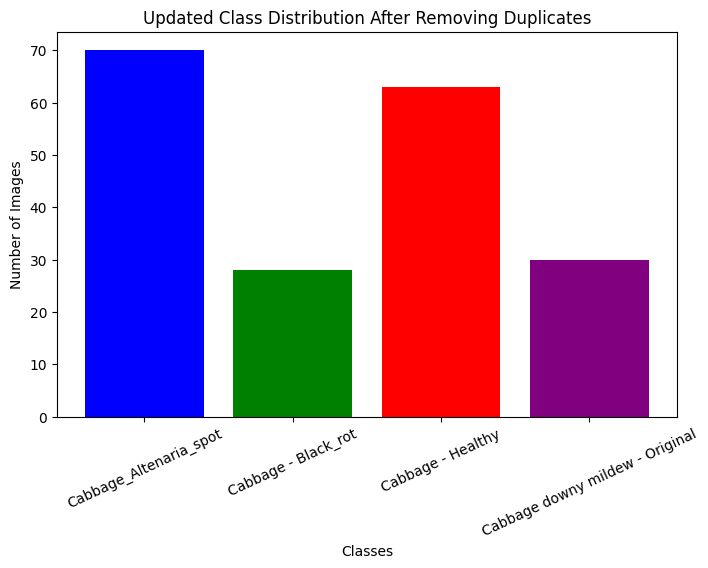

In [11]:
# Count images per class
class_counts = {}
classes = os.listdir(dataset_path)

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))

# Plot the updated class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Updated Class Distribution After Removing Duplicates")
plt.xticks(rotation=25)
plt.show()

**Updated Image Count Per Class After Removing Duplicates**

This code counts the number of images in each class after removing duplicates and prints the updated counts. It ensures that only directories are considered as classes and then iterates through them to count the number of images in each. Finally, it prints the class names along with the corresponding image counts.

In [12]:
# Count images per class
class_counts = {}
classes = os.listdir(dataset_path)

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))

# Print class counts
print("Updated Class Counts After Removing Duplicates:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

Updated Class Counts After Removing Duplicates:
Cabbage_Altenaria_spot: 70 images
Cabbage - Black_rot: 28 images
Cabbage - Healthy: 63 images
Cabbage downy mildew - Original: 30 images


**Convert Images to Numpy and Check Mean Pixel Value**

This code calculates and visualizes the distribution of mean pixel values for a subset of images in the dataset. It processes up to 10 images per class, converts them to RGB format, normalizes pixel values to the range [0,1], and computes the mean pixel value for each image. These values are then plotted using a histogram with kernel density estimation (KDE) to show the frequency distribution of mean pixel intensities

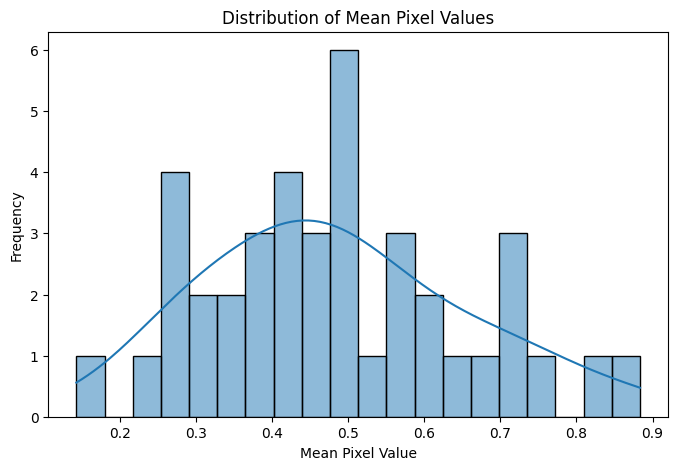

In [13]:
mean_pixel_values = []

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)[:10]  # Limit to 10 images per class

    for img_name in images:
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert("RGB")
        img_array = np.array(img) / 255.0  # Normalize

        mean_pixel_values.append(img_array.mean())

plt.figure(figsize=(8, 5))
sns.histplot(mean_pixel_values, bins=20, kde=True)
plt.xlabel("Mean Pixel Value")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Pixel Values")
plt.show()

**Check for Corrupt Images**

This function checks for corrupt images in the dataset by attempting to open and verify each image file. If an image cannot be opened, it is flagged as corrupt and added to a list. The function then prints the total number of corrupt images found and returns the list of corrupt image paths.

In [14]:
def check_corrupt_images(dataset_path, classes):
    corrupt_images = []

    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Verify if image is valid
            except Exception as e:
                corrupt_images.append(img_path)

    print(f"Found {len(corrupt_images)} corrupt images.")
    return corrupt_images

corrupt_images = check_corrupt_images(dataset_path, classes)

Found 0 corrupt images.


**Resizing Images**

This code sets the image size to 224x224 pixels for consistency and defines a batch size of 32 for efficient processing during model training.

In [15]:
img_size = (224, 224)
batch_size = 32

**Data Augmentation and Normalization**

This code initializes an ImageDataGenerator for data augmentation, applying transformations like rescaling, rotation, shifting, shearing, zooming, and flipping to enhance model generalization while reserving 20% of the data for validation.

In [16]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2,
    channel_shift_range=0
)

**Training Data Generator with Augmentation for Multi-Class Classification**

This code creates a training data generator that loads images from the dataset directory, resizes them to 224x224 pixels, applies data augmentation, and organizes them into batches of 32, using categorical labels for multi-class classification.

In [17]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 153 images belonging to 4 classes.


**Validation Data Generator with Rescaling for Multi-Class Classification**

This code creates a validation data generator that loads images from the dataset directory, resizes them to 224x224 pixels, applies rescaling, and organizes them into batches of 32, using categorical labels for multi-class classification.

In [18]:
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 36 images belonging to 4 classes.


**Visualizing a Batch of Training Images in a 3x3 Grid**

This code retrieves a batch of images and their labels from the training generator, then displays the first 9 images in a 3x3 grid using Matplotlib.









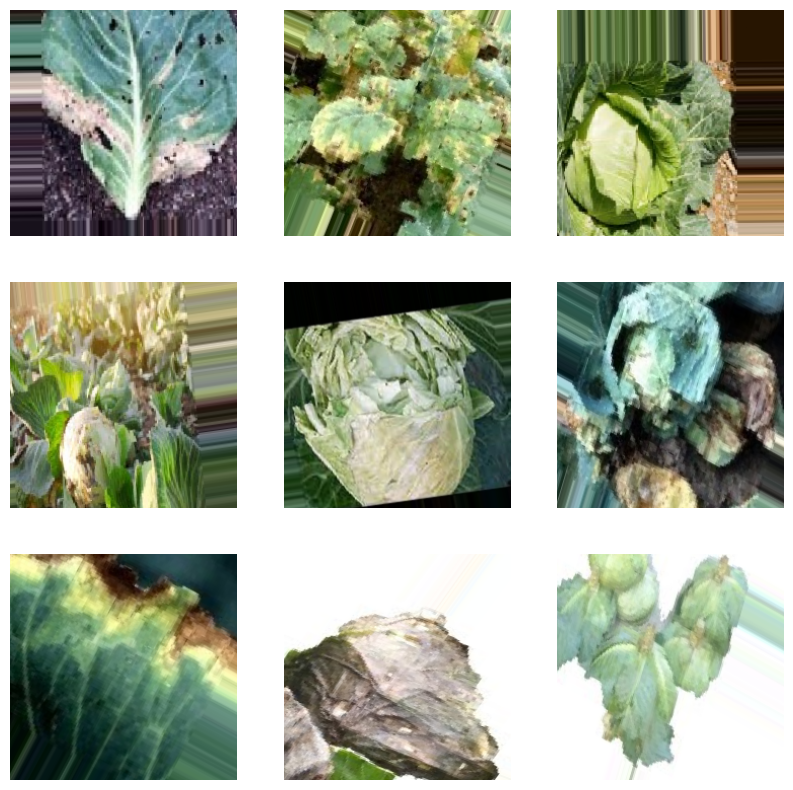

In [19]:
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

**Defining a CNN Model for Multi-Class Image Classification**

This function defines a Convolutional Neural Network (CNN) model with three convolutional layers for feature extraction, max pooling layers for dimensionality reduction, a fully connected layer for classification, and a dropout layer to prevent overfitting. The final layer uses a softmax activation function to classify images into multiple categories.

In [20]:
# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

**Configuring the CNN Model for Training**

This code sets up the CNN model for training by defining the image input size and the number of output classes. It then initializes the model using the previously defined create_cnn_model function and compiles it with the Adam optimizer, categorical cross-entropy loss (suitable for multi-class classification), and accuracy as the evaluation metric.

In [23]:
# Model parameters
img_size = (224, 224, 3)  # Image dimensions
num_classes = len(classes)  # Number of disease categories

# Create model
model = create_cnn_model(img_size, num_classes)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Training the CNN Model with Validation**

This code trains the CNN model using the training dataset (train_generator) and evaluates it on the validation dataset (validation_generator) for 20 epochs, displaying training progress (verbose=1).

In [24]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.3320 - loss: 2.1794 - val_accuracy: 0.1111 - val_loss: 1.3992
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.3001 - loss: 1.3719 - val_accuracy: 0.4167 - val_loss: 1.2663
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.4428 - loss: 1.2516 - val_accuracy: 0.5833 - val_loss: 1.2217
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.5031 - loss: 1.1817 - val_accuracy: 0.5556 - val_loss: 1.2052
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.4649 - loss: 1.2165 - val_accuracy: 0.2778 - val_loss: 1.3273
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.4155 - loss: 1.2151 - val_accuracy: 0.4167 - val_loss: 1.3583
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.3599 - loss: 1.3472 - val_accuracy: 0.3611 - val_loss: 1.2280
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.4654 - loss: 1.2273 - val_accuracy: 0.5556 - val_loss: 1.1925


**Evaluating the Trained Model on the Validation Dataset**

This code evaluates the trained model on the validation dataset and prints the validation accuracy as a percentage.

In [25]:
# Evaluate model
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5764 - loss: 1.3020
Validation Accuracy: 58.33%
